In [1]:
import os
import re
import dotenv
import numpy as np
import pandas as pd
from pprint import pprint

# sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.manifold import TSNE

# utils
from stop_words import get_stop_words
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# spacy for lemmatization
import spacy

# Plotting tools
import seaborn as sns
from wordcloud import WordCloud

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

import pyLDAvis

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

2023-10-08 15:33:14.583753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 15:33:15.373317: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-08 15:33:15.373451: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-1

In [2]:
# Load environment variables
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')

dotenv.load_dotenv(dotenv_path)

True

In [3]:
# read input and agg daily measurements to first()
df = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/interim/data_message_texts_ready_to_topic_modelling.csv', encoding='UTF-8')
#df = pd.read_csv(os.path.join(os.getenv('SAVE_INTERIM_FILES_PATH'), 'data_message_texts_ready_to_topic_modelling.csv'), encoding='UTF-8')
df = df.drop_duplicates('text_clean_and_translated')

In [4]:
df

,Message Text,Date,Impressions,Comments,Likes,Shares,Other Engagements,Engagements,days_since_posted,fanpage_id,ID,has_any_image,hashtags,has_any_hashtag,dow_posted,post_len,timestamp_posted,hm_posted,hour_posted,text_clean_and_translated
0,2023 – the year of #ChatGPT and Co. 🤯 Will gen...,2023-04-18 00:00:00,186.0,NaN,NaN,NaN,1.0,1.0,12.0,157764.0,urn:li:share:7049687219682299905,False,"AI,ArtificialIntelligence,ChatGPT,GenerativeAI...",True,Thursday,730,2023-04-06 12:20:10.694,12:20,12,2023 the year of and co. will generative ai ch...
1,Smart Mechatronix: the perfect ready-to-instal...,2023-07-03 00:00:00,7.0,NaN,NaN,NaN,NaN,NaN,7.0,56825.0,urn:li:share:7079078881395167233,False,Mechatronix,True,Monday,284,2023-06-26 14:52:08.375,14:52,14,smart mechatronix the perfect ready-to-install...
2,"We love oranges so much, we want to extract as...",2023-04-30 00:00:00,1191.0,1.0,14.0,NaN,32.0,47.0,11.0,2269.0,urn:li:share:7054408337148325888,False,"foodindustry,foodingredients,orange,orangeflav...",True,Wednesday,899,2023-04-19 13:00:12.335,13:00,13,"we love oranges so much, we want to extract as..."
3,“Inclusion starts with I” – @[Nadine Ilgenstei...,2023-06-18 00:00:00,788.0,NaN,4.0,NaN,73.0,77.0,6.0,118.0,urn:li:ugcPost:7069950389063667712,False,"Diversity,Inclusion,WeAreSchaeffler",True,Monday,803,2023-06-01 10:18:46.279,10:18,10,"inclusion starts with i , global head of hr st..."
4,MediaMarktSaturn geht den nächsten digitalen S...,2023-05-19 00:00:00,195.0,NaN,1.0,NaN,3.0,4.0,22.0,155056.0,urn:li:share:7057277321598132224,False,"experiencechampion,Retail,Service,Sustainabili...",True,Thursday,773,2023-04-27 11:00:31.505,11:00,11,mediamarktsaturn is taking the next digital st...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85445,📢 Opportunity Alert! 🌟 Join our Social Media T...,2023-06-08 00:00:00,21.0,NaN,NaN,NaN,1.0,1.0,9.0,145481.0,urn:li:ugcPost:7069272909654974464,False,"BoschRexroth,CareerOpportunity,CUBE,JoinOurTea...",True,Tuesday,2014,2023-05-30 13:26:43.492,13:26,13,opportunity alert join our social media team a...
85499,Spændende mulighed: Marketing koordinator hos ...,2023-05-29 00:00:00,11.0,NaN,NaN,NaN,NaN,NaN,7.0,50.0,urn:li:share:7066306460166549504,False,"BoschRexrothCareer,job,marketing",True,Monday,1133,2023-05-22 08:59:05.910,08:59,8,exciting option marketing coordinator at bosch...
85519,Automation live erleben. Heute beginnt die #SM...,2023-05-23 00:00:00,1275.0,2.0,23.0,1.0,47.0,73.0,0.0,50.0,urn:li:share:7066744349828501504,False,"Automation,CertifiedExcellence,ctrlX,I40,SMART...",True,Tuesday,623,2023-05-23 13:59:06.979,13:59,13,experience automation live.today the in linz b...
85559,Webinarium 25.05.2023: Ekstremalne ciepło i tr...,2023-05-24 00:00:00,61.0,NaN,NaN,NaN,NaN,NaN,0.0,50.0,urn:li:share:7067017155375968256,False,"BoschRexroth,metalurgia,webinar",True,Wednesday,929,2023-05-24 08:03:08.884,08:03,8,"webinar May 25, 2023 extreme heat and difficul..."


In [5]:
# CONSTANTS
en_stop = get_stop_words('en')
en_stop.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
en_stop.extend(['aftermarket', 'aren', 'bank', 'barmer', 'bosch', 'brasil', 'can', 'ceconomy', 'couldn', 'covestro', 'deutsche', 'dhl', 'didn', 'doesn', 'don', 'dpdhl', 'global', 'group', 'hadn', 'hagglunds', 'hartmann', 'hasn', 'haspa', 'haven', 'henkel', 'isn', 'korber', 'krones', 'let', 'markt', 'media', 'mediamarkt', 'mediamarktsaturn', 'mustn', 'nagra', 'post', 'rexroth', 'saturn', 'schaeffler', 'shan', 'shouldn', 'sonova', 'sparkasse', 'symrise', 'vdi', 'verein', 'wacker', 'wasn', 'weren', 'won', 'wouldn'])
#add_words_to_exc = ['see', 'day', 'year', 'make', 'new', 'video', 'barmer', 'tomorrow', 'hashtag']
# filter possible company names from text
# companies = ['bosch', 'rexroth', 'schaeffler', 'koerber', 'symrise', 'dhl', 'dpdhl', 'barmer', 'nagra', 'boschrexroth', 'vdi']
#en_stop.extend(add_words_to_exc)
en_stop.extend(os.getenv('COMPANIES').lower().split())

In [8]:
# FUNCTIONS
clean_up_text = lambda text: simple_preprocess( str(text), max_len=100_000, deacc=True )


def lemmatize_text(text, allowed_tags, vocab):
    """https://spacy.io/api/annotation"""
    doc = vocab(" ".join(text))
    return " ".join([token.lemma_ for token in doc if token.pos_ in allowed_tags])

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
# handle later

def compute_c_v_coherence(lda_model, corpus, texts):
    """
    Compute the c_v coherence score for an LDA topic model.
    """
    c_v_coherence_model = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, coherence='c_v')
    return c_v_coherence_model.get_coherence()

def compute_u_mass_coherence(lda_model, corpus, texts):
    """
    Compute the u_mass coherence score for an LDA topic model.
    """
    u_mass_coherence_model = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, coherence='u_mass')
    return u_mass_coherence_model.get_coherence()



# plotting

def format_topics_sentences(ldamodel, vectorizer, texts):
    # Init output
    sent_topics_df = pd.DataFrame(columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Get the document-topic distribution from the LDA model
    doc_topic_dists = ldamodel.transform(vectorizer.transform(texts))

    for i, row in enumerate(doc_topic_dists):
        dominant_topic = row.argmax()
        prop_topic = row.max()
        topic_keywords = ",".join([vectorizer.get_feature_names_out()[i] for i in ldamodel.components_[dominant_topic].argsort()[:-5 - 1:-1]])

        new_row = pd.Series([dominant_topic, round(prop_topic, 4), topic_keywords],
                            index=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
        sent_topics_df = pd.concat([sent_topics_df, new_row.to_frame().T], ignore_index=True)

    # Combine the results with the original text
    sent_topics_df = pd.concat([sent_topics_df, pd.Series(texts, name='Text')], axis=1)

    return sent_topics_df

In [9]:
# Convert to list
data = df.text_clean_and_translated.values.tolist()
#weights = df.class_weight.values.tolist()
post_ids = df.ID.values.tolist()

In [10]:
# removing punctuations and unnecessary characters
# no max len for a token
# deacc=True removes punctuations
data_words = list(map(clean_up_text, data))
print(data_words[:1])

[['the', 'year', 'of', 'and', 'co', 'will', 'generative', 'ai', 'change', 'the', 'industry', 'our', 'cdo', 'has', 'been', 'exploring', 'this', 'question', 'ever', 'since', 'he', 'witnessed', 'the', 'initial', 'hype', 'live', 'in', 'silicon', 'valley', 'at', 'the', 'beginning', 'of', 'the', 'year', 'read', 'his', 'detailed', 'article', 'below', 'learn', 'more', 'about', 'why', 'generative', 'is', 'so', 'appealing', 'to', 'the', 'masses', 'how', 'this', 'one', 'ai', 'technology', 'will', 'shape', 'the', 'next', 'decade', 'the', 'difficult', 'balance', 'of', 'security', 'and', 'and', 'europes', 'role', 'in', 'it', 'possible', 'industrial', 'cases', 'and', 'next', 'steps', 'for', 'entrepreneurs', 'what', 'do', 'you', 'think', 'are', 'we', 'currently', 'experiencing', 'big', 'ai', 'wake', 'up', 'call', 'led', 'by', 'chatgpt']]


In [12]:
# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
# Do lemmatization keeping only noun, adj, vb, adv
import functools
data_lemmatized = list(map(
    functools.partial(
        lemmatize_text, 
        vocab=spacy.load('en_core_web_sm', disable=['parser', 'ner']),
        allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']
    ),
    data_words
))

print(data_lemmatized[:1])

['year generative ai change industry cdo explore question ever witness initial hype live silicon valley beginning year read detailed article learn more generative so appealing masse one ai technology shape next decade difficult balance security europe role possible industrial case next step entrepreneur think currently experience big ai wake call lead chatgpt']


In [91]:
vec_ct = CountVectorizer(analyzer='word',
                             min_df=0.1,
                             strip_accents = 'unicode',
                             stop_words=en_stop,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

vec_tfidf = TfidfVectorizer(analyzer='word',
                             min_df=15,
                             stop_words=en_stop,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{4,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

X_ct = vec_ct.fit_transform(data_lemmatized)
X_tfidf = vec_tfidf.fit_transform(data_lemmatized)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gglunds', 'rber'] not in stop_words.
  warnings.warn(


In [106]:
# Create custom scorers
c_v_scorer = make_scorer(compute_c_v_coherence, greater_is_better=True)
u_mass_scorer = make_scorer(compute_u_mass_coherence, greater_is_better=True)

# Define your parameter grid for LDA
param_grid = {
    'n_components': [6, 8, 10],
    'learning_offset': [10],
    'learning_decay': [.7],
    'batch_size': [128]
}

# Create an LDA model
lda_model = LatentDirichletAllocation()
#scoring={'c_v': c_v_scorer, 'u_mass': u_mass_scorer},
# Create a GridSearchCV object with the custom scorers
grid_search_cv = GridSearchCV(lda_model, param_grid, cv=5)

# Fit the grid search
grid_search_cv.fit(X_tfidf)  # Replace 'corpus' with your data

GridSearchCV(cv=5, estimator=LatentDirichletAllocation(),
             param_grid={'batch_size': [128], 'learning_decay': [0.7],
                         'learning_offset': [10], 'n_components': [6, 8, 10]})

In [107]:
# Best Model
best_lda_model = grid_search_cv.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid_search_cv.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", grid_search_cv.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X_tfidf))

Best Model's Params:  {'batch_size': 128, 'learning_decay': 0.7, 'learning_offset': 10, 'n_components': 6}
Best Log Likelihood Score:  -34215.26995286431
Model Perplexity:  2616.1821154556064


/tmp/ipykernel_117/3990590850.py:6: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.lineplot(data=results,


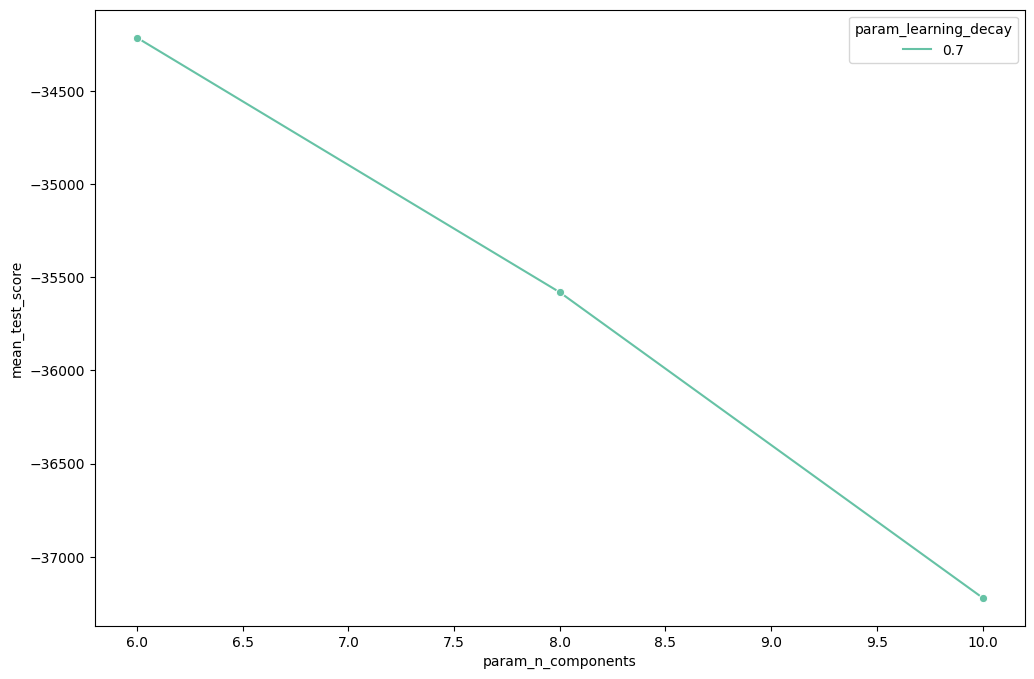

In [108]:
results = pd.DataFrame(grid_search_cv.cv_results_)
current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(12,8))

sns.lineplot(data=results,
             x='param_n_components',
             y='mean_test_score',
             hue='param_learning_decay',
             # https://github.com/mwaskom/seaborn/issues/1515
             palette=current_palette,
             marker='o'
            )

# # Would need a good way to show three error bars
# plt.errorbar(x=results['param_n_components'],
#              y=results.mean_test_score,
#              yerr=results.std_test_score,
#              fmt='none',
#              color=current_palette[0])

plt.show()

In [22]:
# Values for the above plot
results[['param_learning_decay',
         'param_n_components',
         'mean_test_score']].pivot_table(columns=['param_learning_decay',
                                  'param_n_components'])

param_learning_decay         0.4                       0.7               \
param_n_components             6            9            6            9   
mean_test_score      -2790.98089 -3054.284714 -2792.379644 -3056.258772   

param_learning_decay        0.9               
param_n_components            6            9  
mean_test_score      -2795.4063 -3055.561692

In [23]:
# std for the values in the above plot
results[['param_learning_decay',
         'param_n_components',
         'std_test_score']].pivot_table(columns=['param_learning_decay',
                                  'param_n_components'])

param_learning_decay        0.4                   0.7                   0.9  \
param_n_components            6          9          6          9          6   
std_test_score        57.510628  65.075538  58.805669  61.264148  52.312173   

param_learning_decay             
param_n_components            9  
std_test_score        61.651884

In [109]:
# Visualize the topics
pyLDAvis.enable_notebook()
pyLDAvis_data = pyLDAvis.prepare(
    topic_term_dists = best_lda_model.components_ / best_lda_model.components_.sum(axis=1)[:, np.newaxis],
    doc_topic_dists = best_lda_model.transform(X_tfidf),
    doc_lengths = X_tfidf.sum(axis=1).A1,
    vocab = vec_tfidf.get_feature_names_out(),
    term_frequency = X_tfidf.sum(axis=0).A1,
)
pyLDAvis.display(pyLDAvis_data)

In [110]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(X_tfidf)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc0,0.870000,0.030000,0.030000,0.030000,0.030000,0.030000,0
Doc1,0.030000,0.030000,0.030000,0.030000,0.840000,0.030000,4
Doc2,0.440000,0.030000,0.030000,0.450000,0.030000,0.030000,3
Doc3,0.830000,0.030000,0.030000,0.030000,0.030000,0.030000,0
Doc4,0.630000,0.030000,0.260000,0.030000,0.030000,0.030000,0
Doc5,0.120000,0.030000,0.470000,0.030000,0.300000,0.030000,2
Doc6,0.840000,0.030000,0.030000,0.030000,0.030000,0.030000,0
Doc7,0.550000,0.020000,0.210000,0.030000,0.160000,0.030000,0
Doc8,0.370000,0.030000,0.400000,0.150000,0.030000,0.030000,2
Doc9,0.830000,0.030000,0.030000,0.030000,0.030000,0.030000,0


In [100]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,1931
1,3,1332
2,2,725
3,1,180


In [111]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vec_tfidf.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,ability,able,accelerate,accept,access,accompany,accord,account,accuracy,achieve,...,workshop,world,worldwide,worth,wound,write,year,yesterday,young,youth
Topic0,3.124030,15.267361,1.697365,0.569087,2.766887,3.669208,3.465138,2.942706,0.166967,10.129403,...,12.300887,28.734372,6.073383,0.188318,3.605500,3.796464,57.610620,6.472774,15.974158,3.796814
Topic1,0.167142,0.589589,0.166975,0.166782,0.862228,0.422298,0.292571,4.691408,0.166691,0.166929,...,0.167062,0.168135,0.167591,0.170463,0.166883,0.360451,0.737995,0.557950,0.167002,0.166690
Topic2,1.904399,2.676588,2.248721,1.158329,5.737992,0.413378,1.192068,0.480943,4.100453,4.318298,...,0.845569,9.934077,1.627612,1.709070,0.166674,1.615209,5.062664,0.167032,0.166742,0.166718
Topic3,0.200437,2.824666,1.990759,2.528974,3.811603,0.166981,4.244645,1.632410,0.166671,8.110714,...,0.659912,5.678041,3.809587,4.118140,0.167613,0.169370,16.674170,1.719875,0.166994,0.166998
Topic4,0.167774,2.830061,0.611589,0.169207,0.544862,0.171819,1.567057,1.867107,0.326960,3.566301,...,0.941610,8.524680,0.874106,0.168506,10.124137,0.171247,8.461096,1.578675,0.166857,0.166668


In [112]:
topic_keywords = show_topics(vectorizer=vec_tfidf, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,work,year,team,employee,opportunity,company,together,business,career,future,award,look,support,colleague,great
Topic 1,tractor,episode,podcast,repository,tour,deep,foam,century,listen,adhesive,home,polyurethane,insulation,account,vote
Topic 2,system,solution,machine,drive,service,hydraulic,technology,automation,repair,control,product,hagglund,component,vehicle,maintenance
Topic 3,energy,climate,sustainable,sustainability,reduce,water,year,emission,project,carbon,protection,material,future,goal,waste
Topic 4,solution,booth,visit,find,automation,show,technology,look,stand,meet,product,learn,system,production,expert
Topic 5,hashtag,partner,today,student,training,festival,program,child,site,fragrance,start,summer,dual,hand,access


In [117]:
# Format
df_dominant_topic = format_topics_sentences(best_lda_model, vec_tfidf, data).reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.5023,"work,year,team,employee,opportunity",2023 the year of and co. will generative ai ch...
1,1,4,0.8316,"solution,booth,visit,find,automation",smart mechatronix the perfect ready-to-install...
2,2,0,0.4682,"work,year,team,employee,opportunity","we love oranges so much, we want to extract as..."
3,3,0,0.8211,"work,year,team,employee,opportunity","inclusion starts with i , global head of hr st..."
4,4,0,0.5725,"work,year,team,employee,opportunity",mediamarktsaturn is taking the next digital st...
5,5,2,0.408,"system,solution,machine,drive,service",lean back and relax you can when you know that...
6,6,0,0.8291,"work,year,team,employee,opportunity",being challenged by limited eyesight has not h...
7,7,0,0.5448,"work,year,team,employee,opportunity","did you know that bees travel more than 100,00..."
8,8,2,0.4276,"system,solution,machine,drive,service",sometimes it just depends on the popometer. wh...
9,9,0,0.8202,"work,year,team,employee,opportunity","last week, the schaeffler iberia sant justo te..."


In [118]:
df_dominant_topic.loc[:, 'ID'] = post_ids
result = pd.merge(
    df,
    df_dominant_topic.loc[:, ['ID', 'Dominant_Topic', 'Topic_Perc_Contrib']],
    on = 'ID',
    how = 'left'
)

In [120]:
result.to_csv('/home/vlsta001/git_projects/machine-learning-project/data/processed/daily_measures_features_full.csv', encoding='utf-8', index=False)

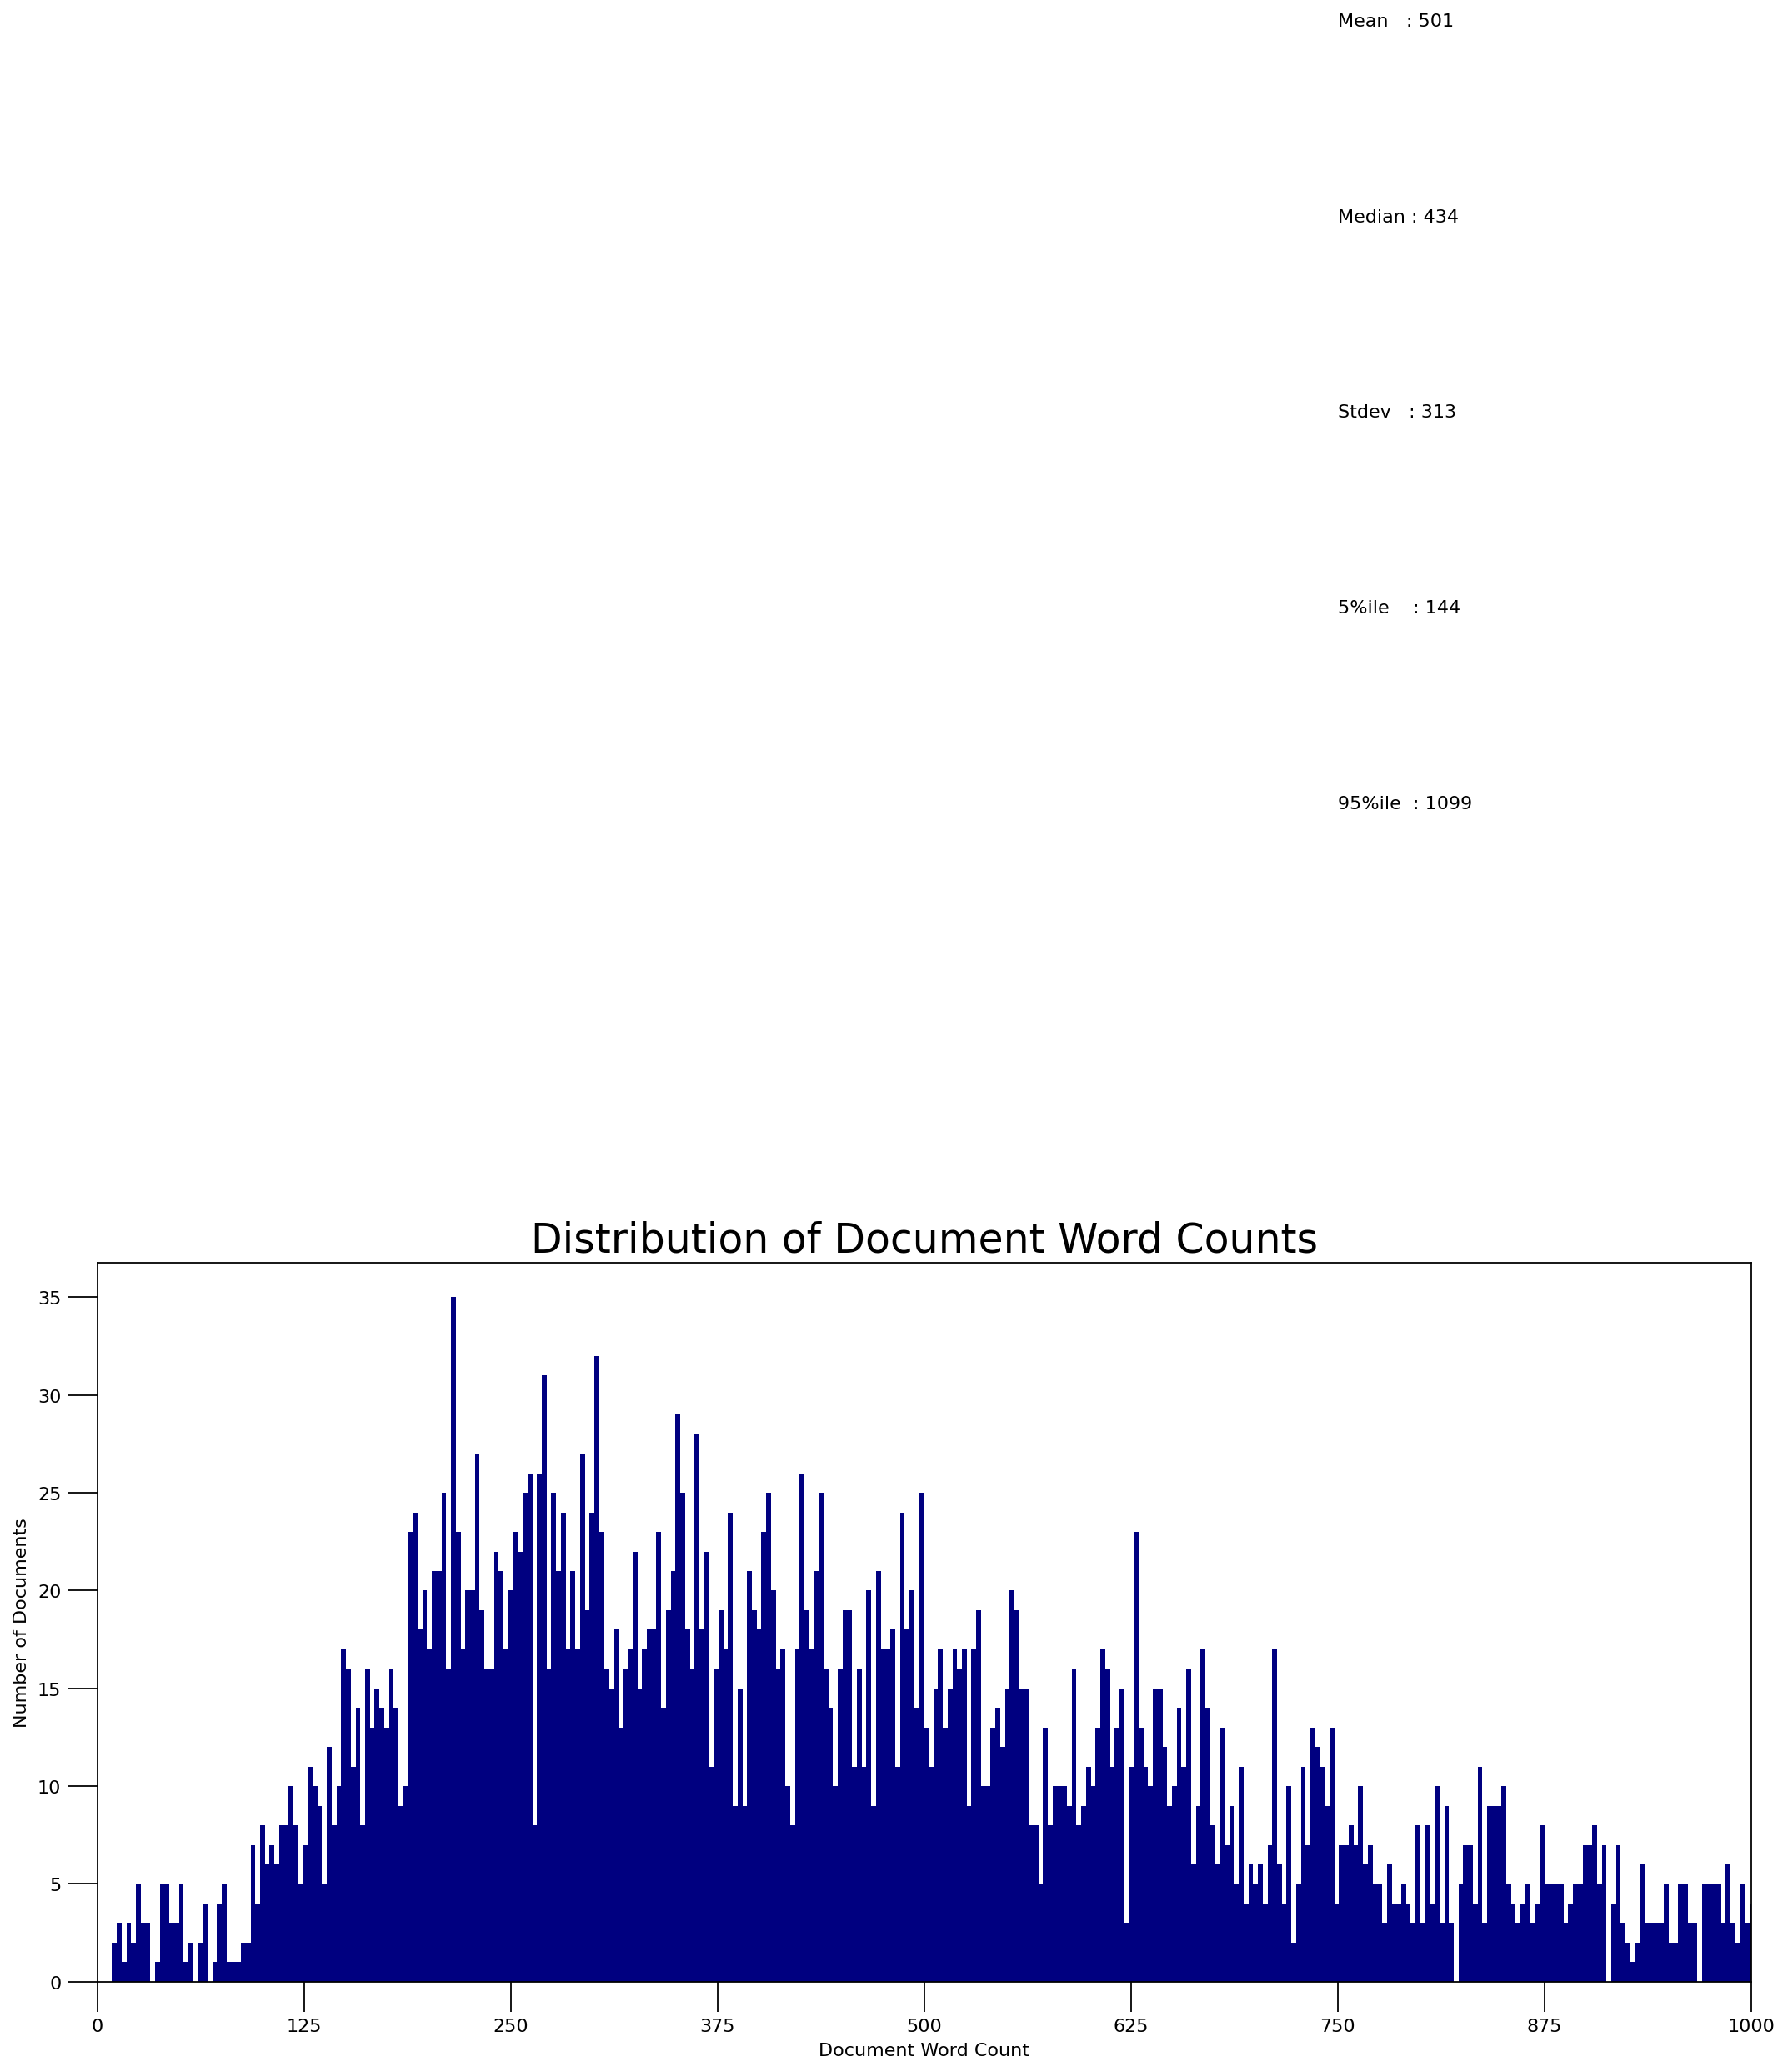

In [104]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "5%ile    : " + str(round(np.quantile(doc_lens, q=0.05))))
plt.text(750,  60, "95%ile  : " + str(round(np.quantile(doc_lens, q=0.95))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

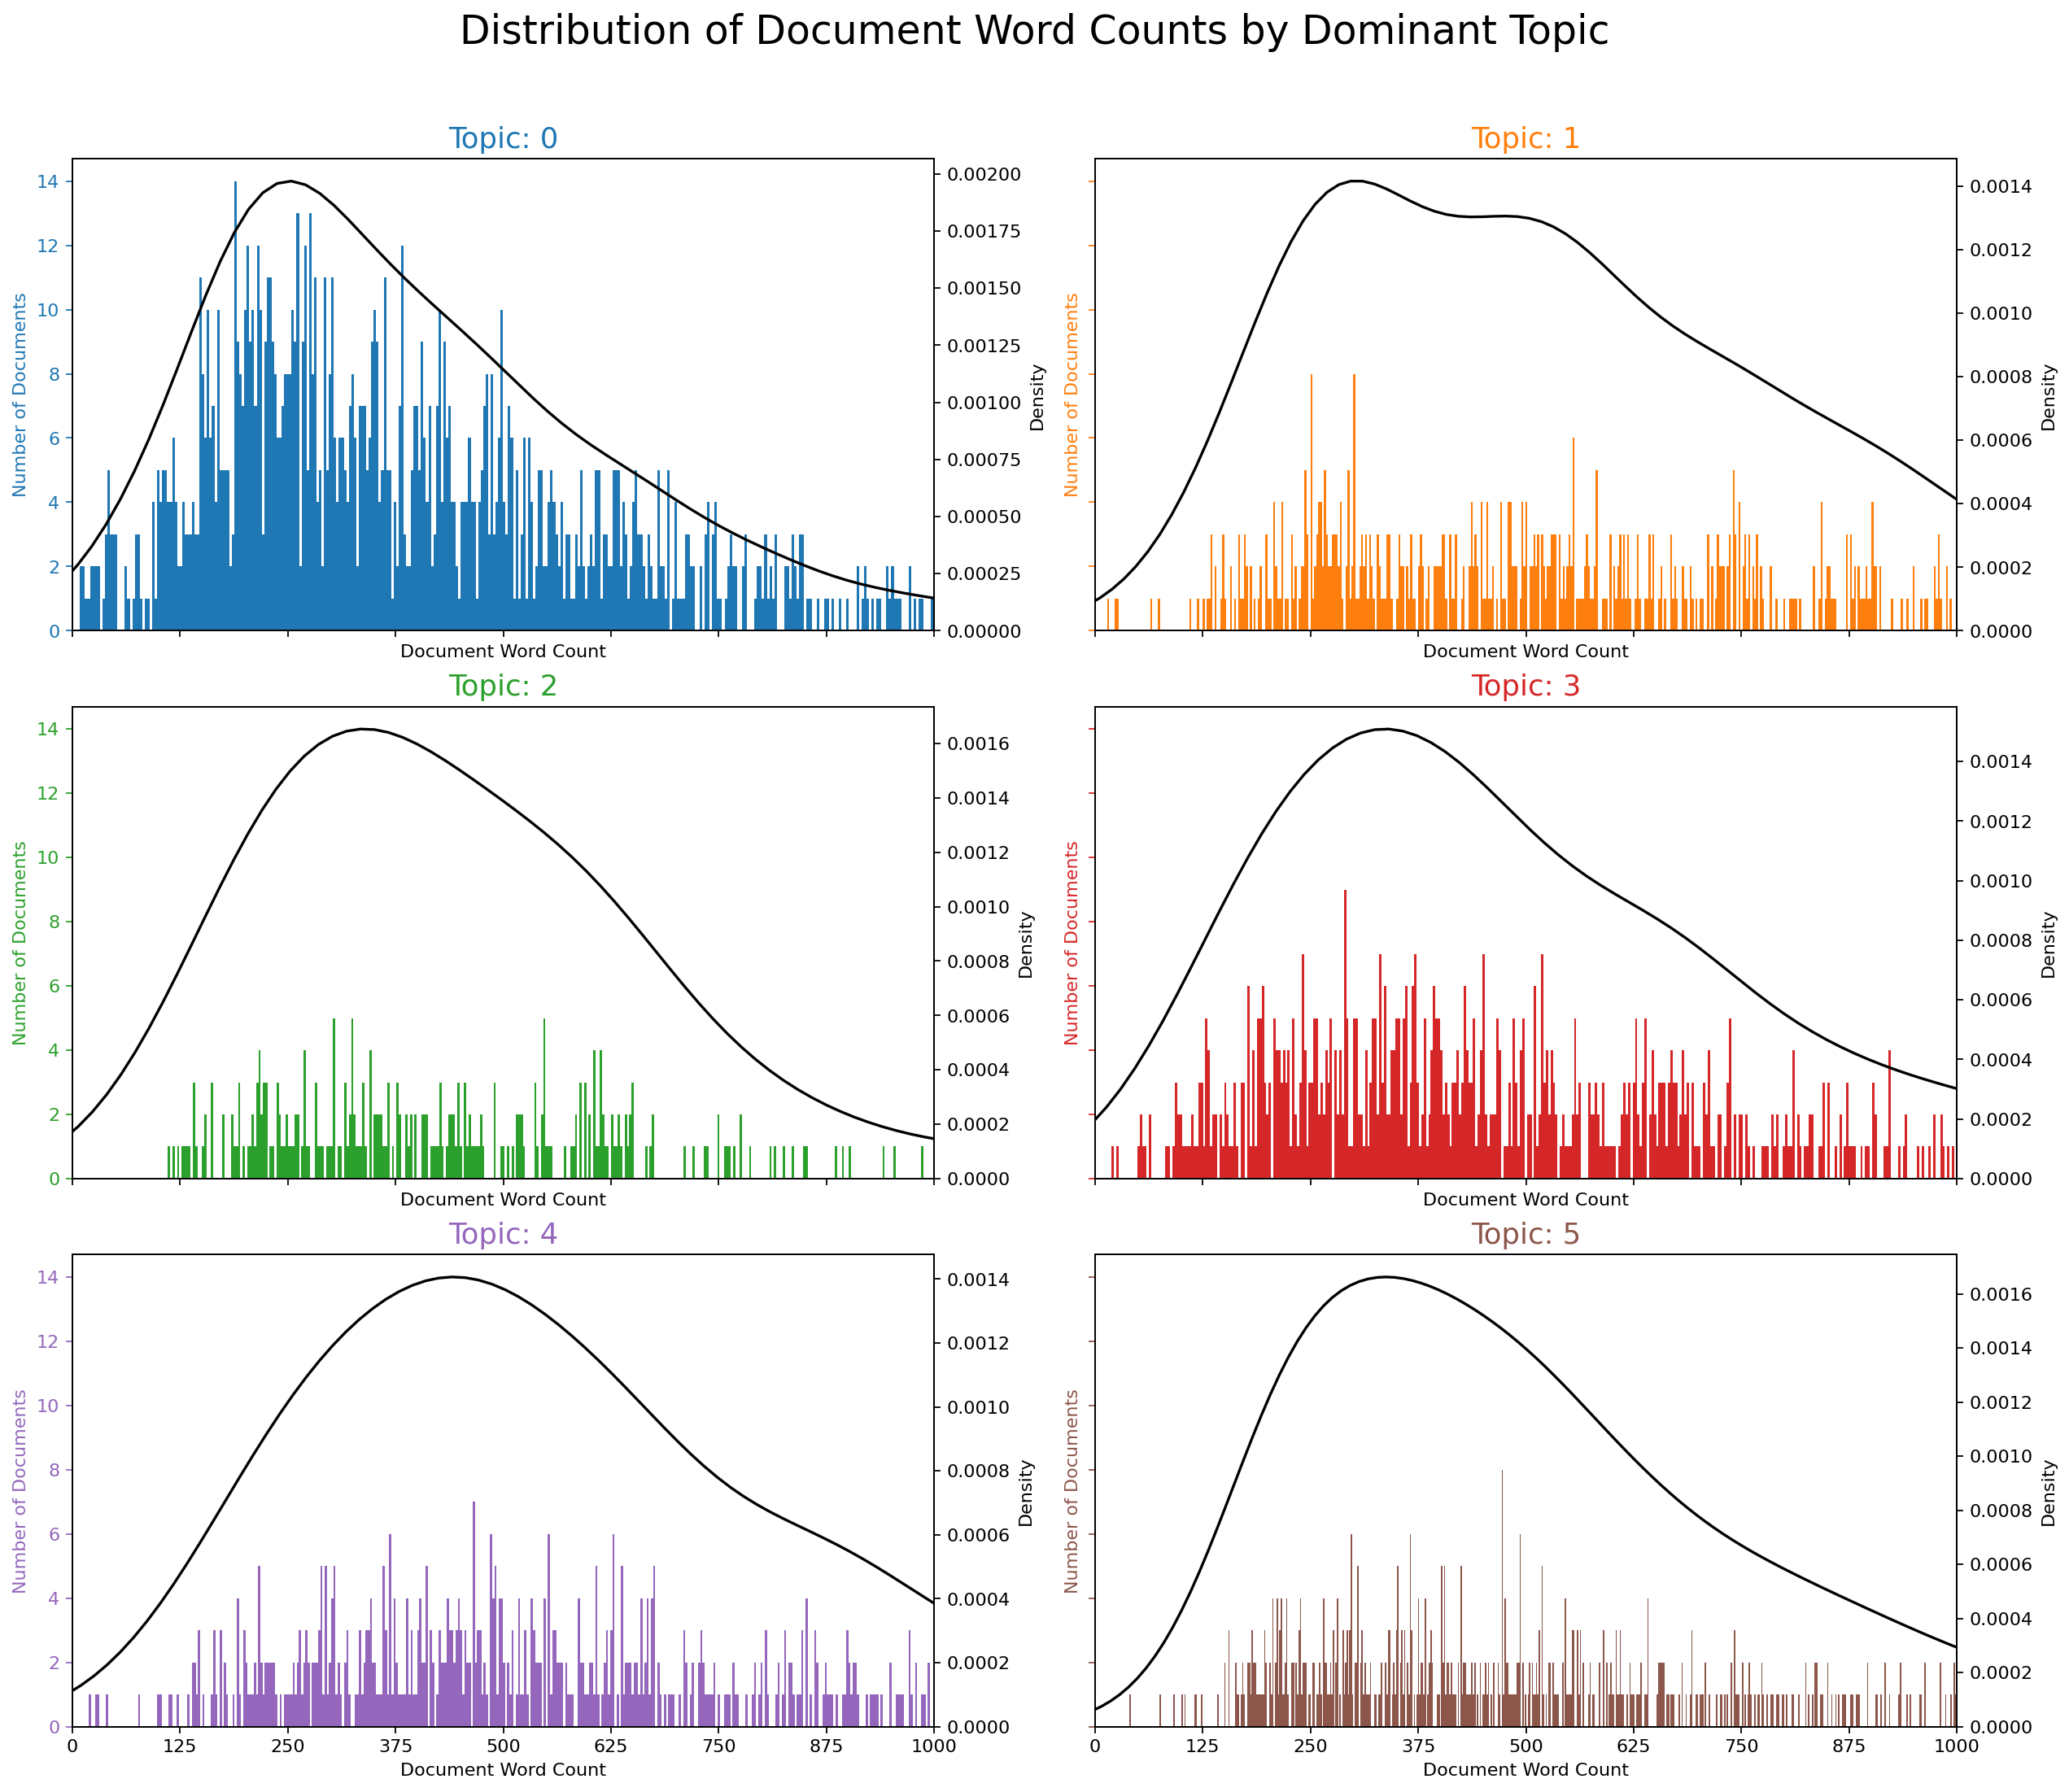

In [98]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

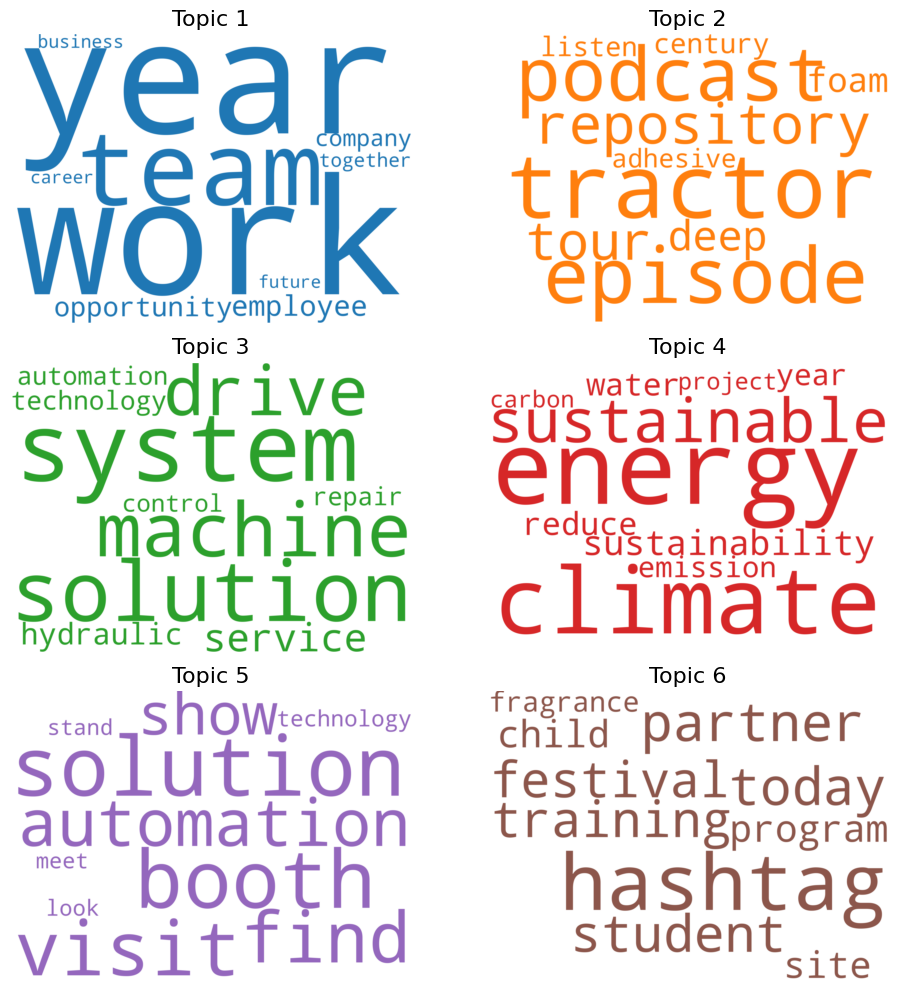

In [122]:
# 1. Wordcloud of Top N words in each topic
num_words = 10  # You can adjust the number of top words
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords='english',
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=num_words,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)


# Assuming you have a trained scikit-learn LDA model 'lda_model' and a vectorizer 'vectorizer'

# Get the top words for each topic from the LDA model
topics = best_lda_model.components_

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(zip(vec_tfidf.get_feature_names_out(), topics[i]))
    top_words = dict(sorted(topic_words.items(), key=lambda x: x[1], reverse=True)[:num_words])
    cloud.generate_from_frequencies(top_words)
    plt.imshow(cloud, interpolation='bilinear')
    plt.title('Topic ' + str(i + 1), size=16)
    plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

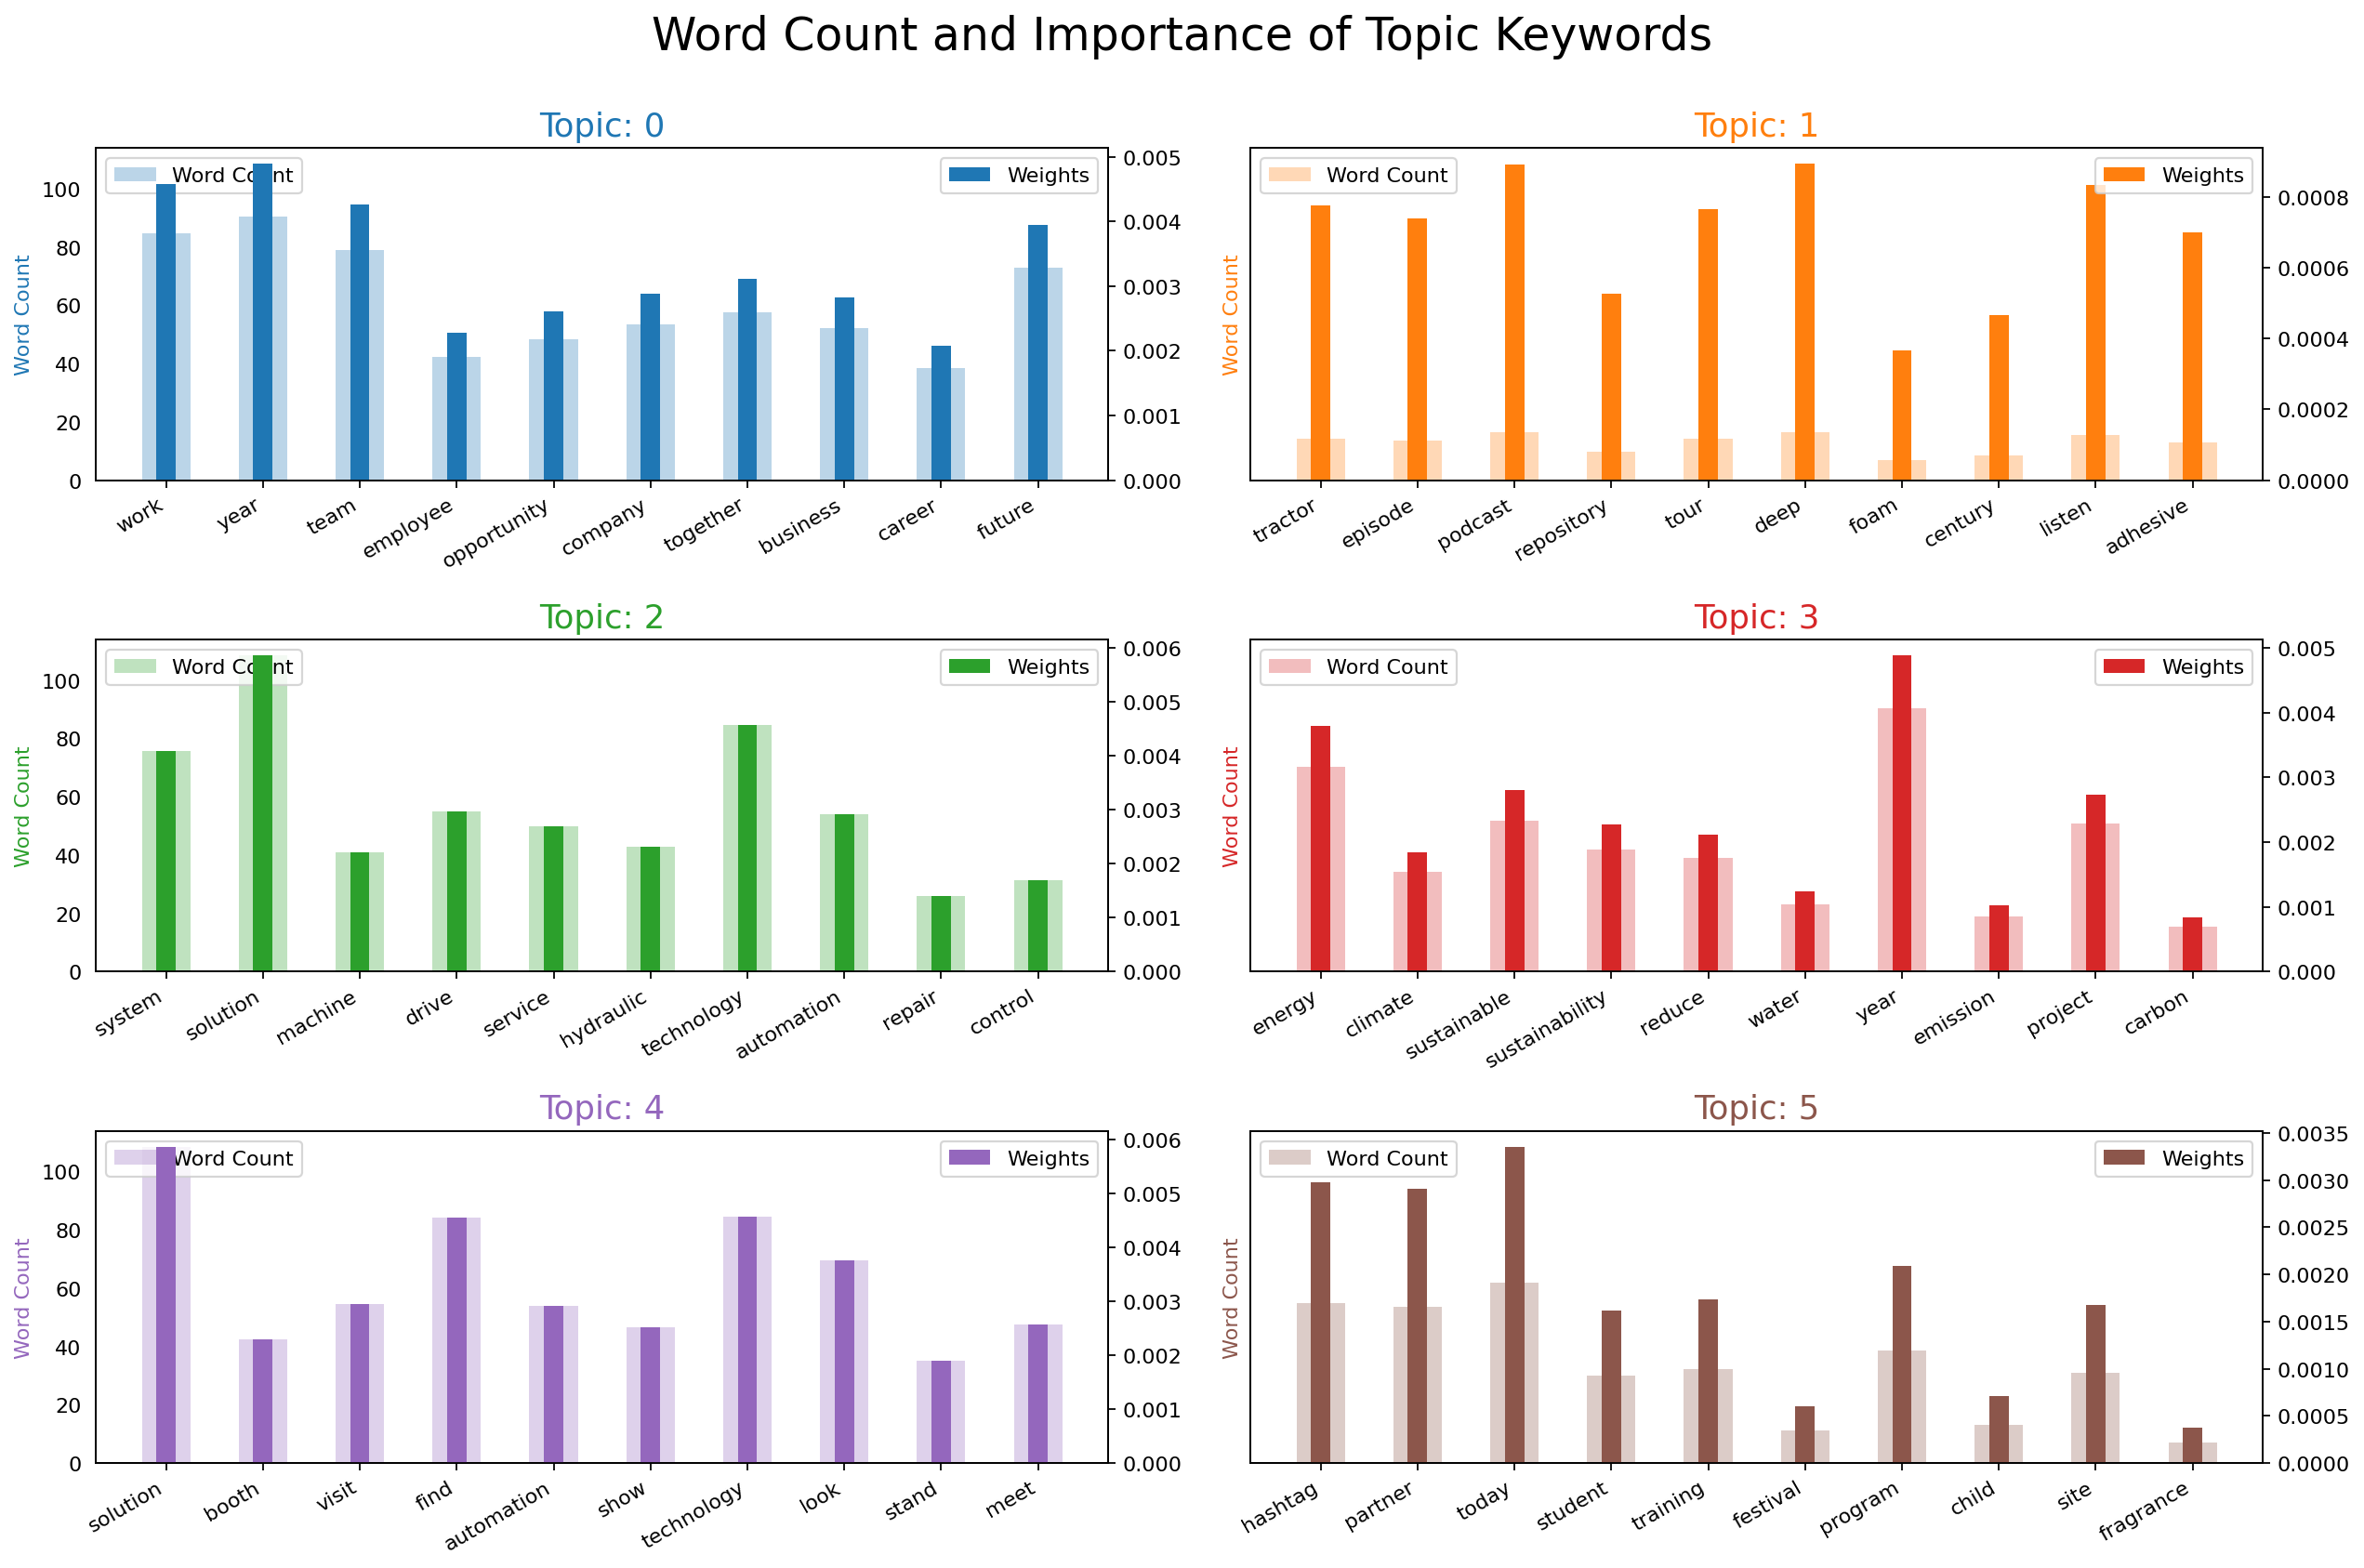

In [123]:
# Get the topics and their top words from the LDA model
num_topics = best_lda_model.n_components
topics = best_lda_model.components_

# Flatten the list of documents and count word occurrences
term_frequencies = X_tfidf.sum(axis=0).A1

# Get the feature names (vocabulary)
vocab = vec_tfidf.get_feature_names_out()

# Create a dictionary to map terms to their frequencies
word_counts = dict(zip(vocab, term_frequencies))

# Initialize a list to store data
out = []

# Iterate through topics and their top words
for i, topic in enumerate(topics):
    top_words = [vec_tfidf.get_feature_names_out()[j] for j in topic.argsort()[-10:][::-1]]  # Adjust the number of top words as needed
    for word in top_words:
        # Get the word count
        word_count = word_counts[word]
        
        # Calculate word importance as word count divided by the total word count
        word_importance = word_count / term_frequencies.sum()
        
        out.append([word, i, word_count, word_importance])

# Create a DataFrame from the collected data
dfK = pd.DataFrame(out, columns=['word', 'topic_id', 'word_count', 'importance'])

max_word_count = dfK['word_count'].max()
max_word_importance = dfK['importance'].max()

fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=dfK.loc[dfK.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=dfK.loc[dfK.topic_id == i, :], color=cols[i], width=0.2, label='Weights')

    # Check if the maximum word count is very small or zero
    if max_word_count < 1e-5:
        y_axis_limit = 0.1  # Set a small non-zero value for the y-axis limit
    else:
        y_axis_limit = max_word_count * 1.2
        
    # if max_word_importance < 1e-5:
    #     y_twin_axis_limit = 0.001
    # else:
    #     y_twin_axis_limit = max_word_importance * 1.2

    #ax.set_ylim(0, y_axis_limit)
    #ax_twin.set_ylim(0, y_twin_axis_limit)

    # Set x-axis tick locations and labels
    x_labels = dfK.loc[dfK.topic_id == i, 'word']
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=30, horizontalalignment='right')

    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)

    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
    

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

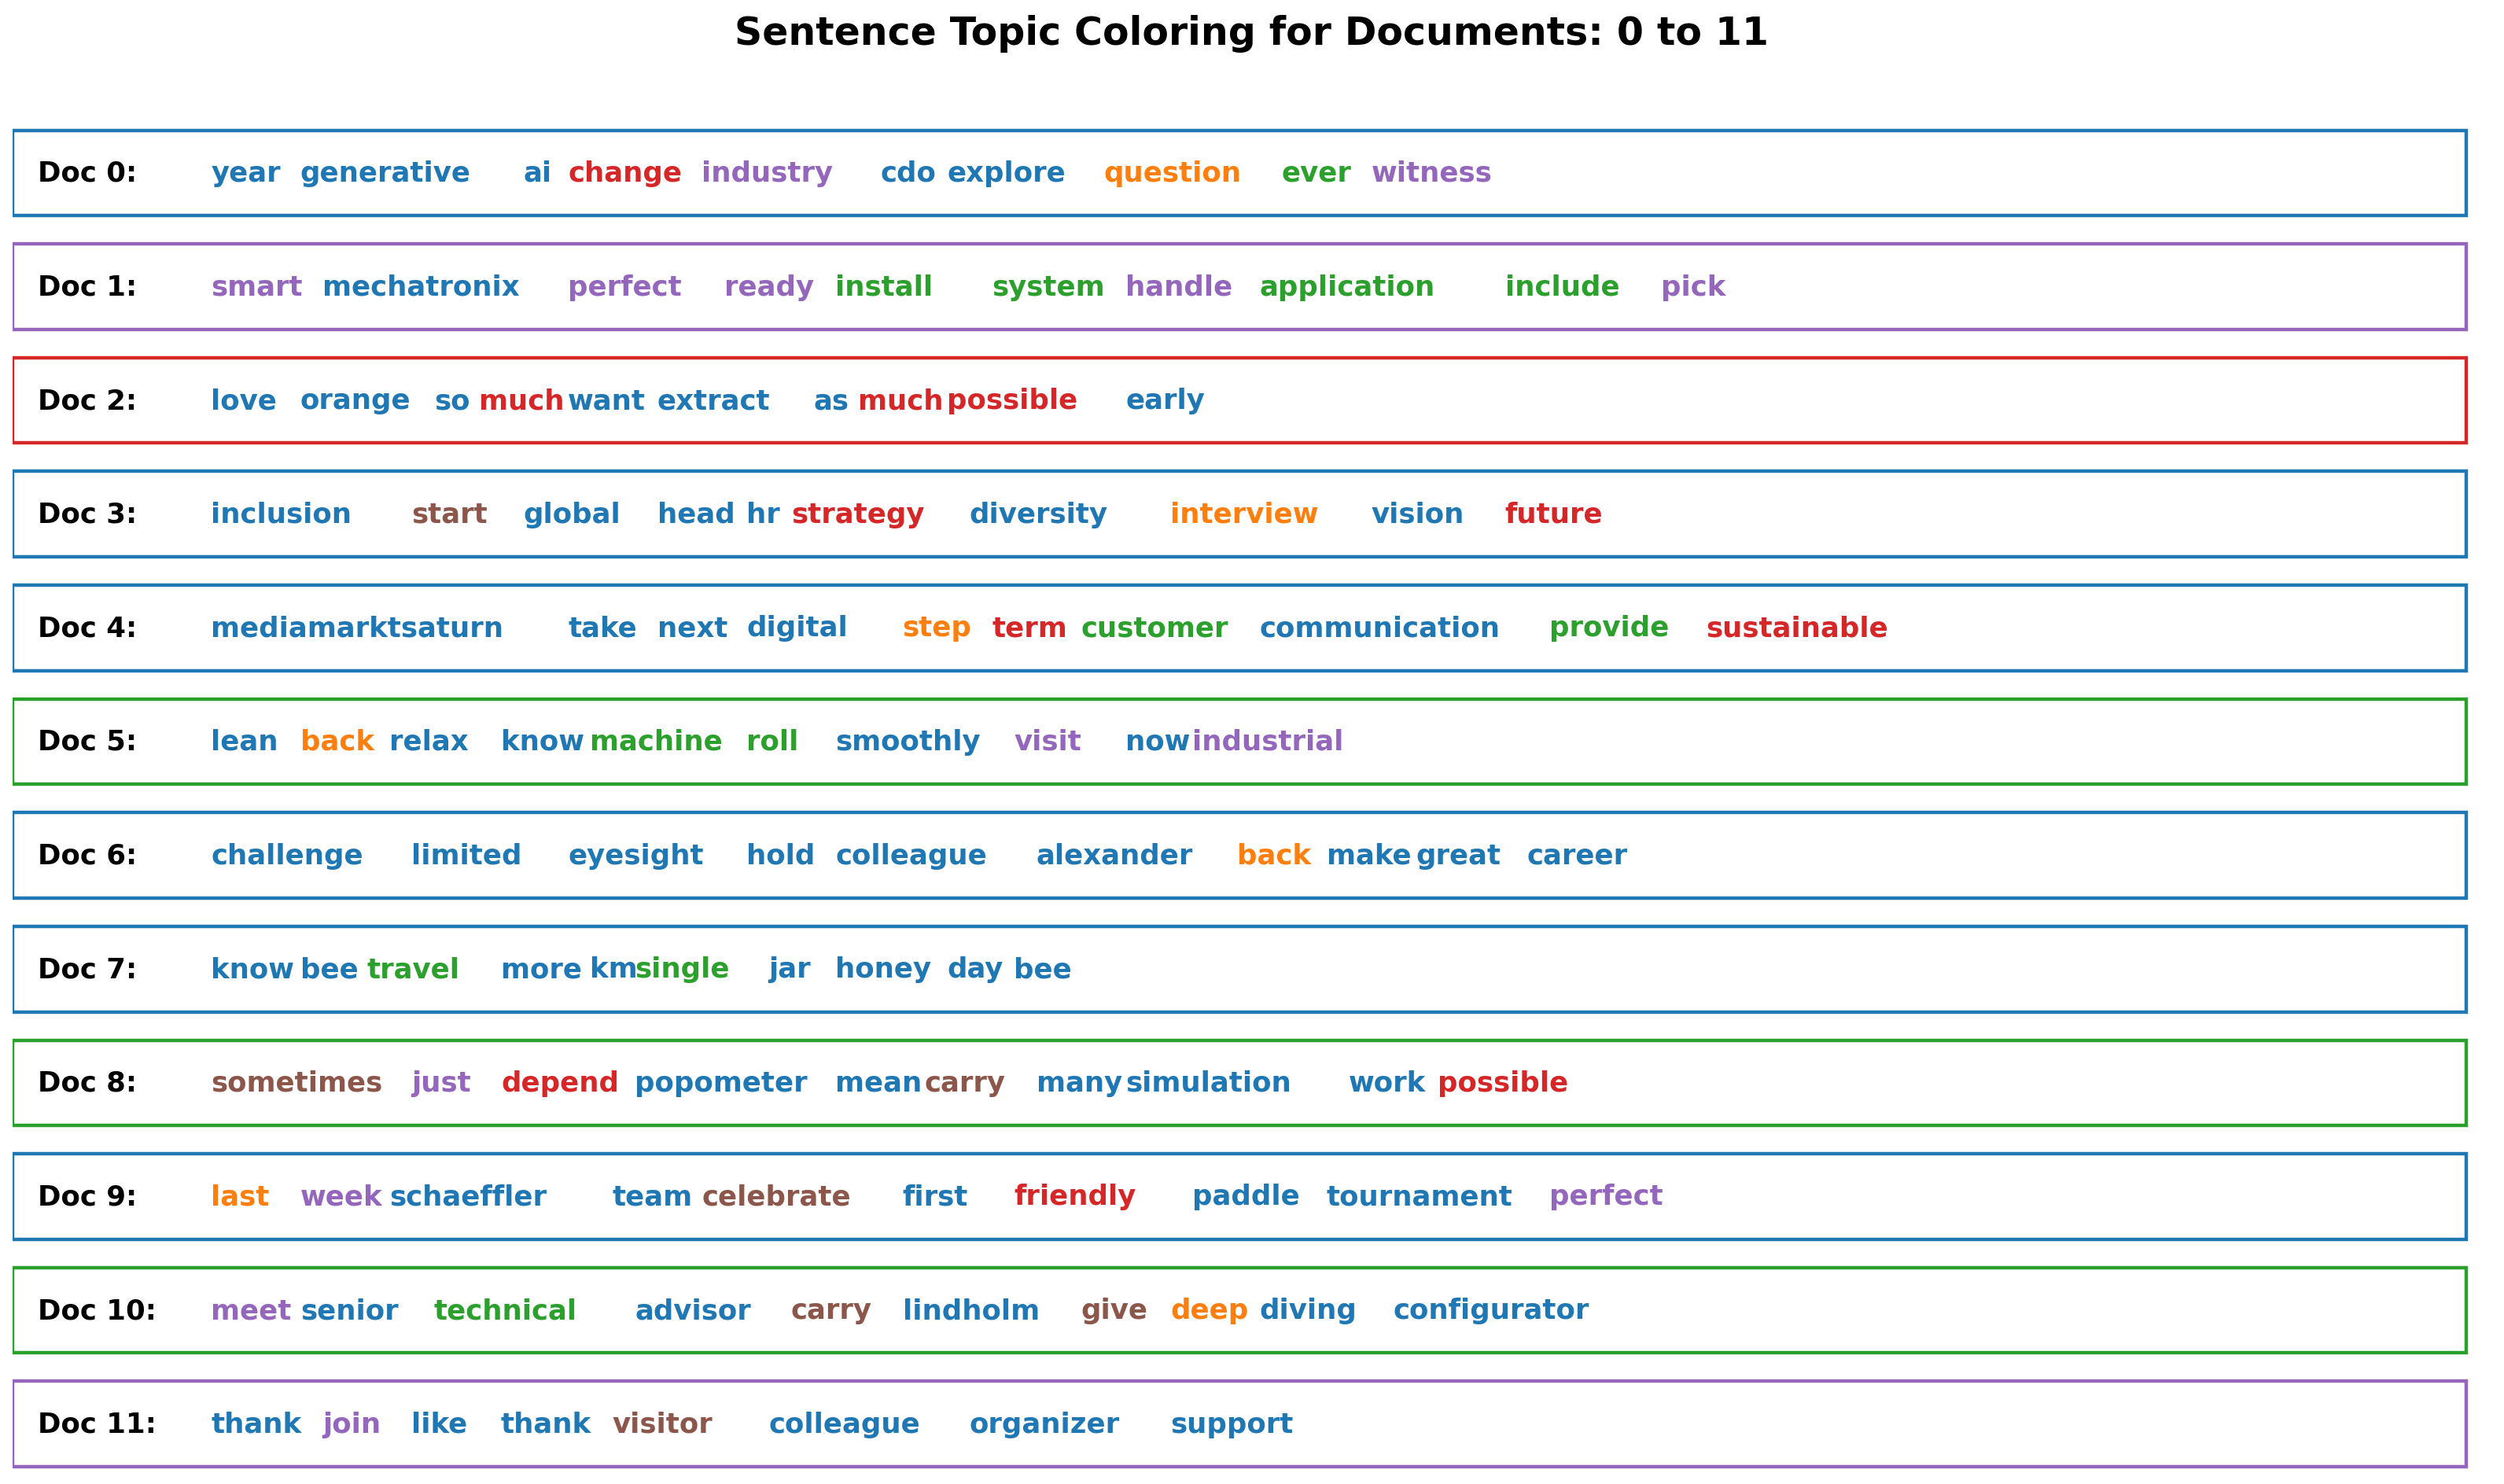

In [124]:
from matplotlib.colors import to_rgba

# Assuming you have a trained scikit-learn LDA model 'lda_model' and a CountVectorizer 'vectorizer'
# You should have 'documents' ready

topic_assignments = best_lda_model.transform(vec_tfidf.transform(data_lemmatized))

# Set the start and end indices for the sentences you want to visualize
start = 0
end = 13

# Get the subset of topic assignments for the selected sentences
topic_assignments_subset = topic_assignments[start:end]

mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

fig, axes = plt.subplots(end - start, 1, figsize=(20, (end - start) * 0.95), dpi=160)
axes[0].axis('off')

for i, ax in enumerate(axes):
    if i > 0:
        doc_topic_probs = topic_assignments_subset[i - 1]

        # Find the dominant topic for the current document
        dominant_topic = np.argmax(doc_topic_probs)
        max_topic_prob = doc_topic_probs[dominant_topic]

        ax.text(0.01, 0.5, "Doc " + str(i - 1) + ": ", verticalalignment='center',
                fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

        # Draw Rectangle
        ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                               color=mycolors[dominant_topic], linewidth=2))
        
        ax.axis('off')

        # Process each word in the document, limited to the first 10 words
        words = data_lemmatized[i - 1].split()[:10]
        word_x_pos = 0.08

        for word in words:
            # Determine the topic associated with the word
            word_topic = np.argmax(best_lda_model.transform(vec_tfidf.transform([word])))

            # Color the word with the topic's color
            ax.text(
                word_x_pos, 
                0.5, 
                word, 
                fontsize=16,
                horizontalalignment='left',
                verticalalignment='center',
                color=mycolors[word_topic],
                transform=ax.transAxes, 
                fontweight=700)
            word_x_pos += 0.009 * len(word)

plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end - 2), fontsize=22, y=0.95, fontweight=700)
plt.tight_layout()
plt.show()

In [127]:
# Get topic weights
topic_weights = best_lda_model.transform(X_tfidf)

# Dominant topic number in each document
topic_num = np.argmax(topic_weights, axis=1)

# t-SNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(topic_weights)

# Plot the Topic Clusters using Matplotlib
n_topics = best_lda_model.n_components
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

# Array of topic weights    
# arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
# topic_num = np.argmax(arr, axis=1)

# Plot the Topic Clusters using Bokeh
output_notebook()
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              width=900, height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4168 samples in 0.003s...
[t-SNE] Computed neighbors for 4168 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4168
[t-SNE] Computed conditional probabilities for sample 2000 / 4168
[t-SNE] Computed conditional probabilities for sample 3000 / 4168
[t-SNE] Computed conditional probabilities for sample 4000 / 4168
[t-SNE] Computed conditional probabilities for sample 4168 / 4168
[t-SNE] Mean sigma: 0.002781
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.524216
[t-SNE] KL divergence after 1000 iterations: 0.401159


Loading BokehJS ...